# Generative Adversarial Networks

In [1]:
# imports 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as pltgrid
import numpy as np
import numpy.random as rng

In [2]:
# neural network class
class neural_net(object):
    ''' Neural Network Class'''
    def __init__(self, layer_sizes, activationFn=tf.nn.relu):
        self.activationFn = activationFn # network activation function
        self.weights = []
        self.biases = []
        for s1,s2 in zip(layer_sizes[0:-1], layer_sizes[1:]):
            # use weight initialization for suitable for relu from https://arxiv.org/pdf/1502.01852.pdf (see also http://cs231n.github.io/neural-networks-2/)
            self.weights += [tf.Variable(tf.truncated_normal(shape=[s1,s2], stddev=tf.sqrt(2./s1)))]
            self.biases += [tf.Variable(tf.zeros(shape= [s2]))]
    ''' Logits function'''
    def get_logits(self, ip):
        h = ip   #initilaize layer with input
        ###  forward pass through network layers ###
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            h = self.activationFn(tf.matmul(h,w)+b)
        return tf.matmul(h, self.weights[-1])+self.biases[-1]
    '''Network output'''
    def out(self, ip):
        return tf.nn.sigmoid(self.get_logits(ip))

In [3]:
''' digits plotting function'''
def plot_digits(digits):
    l = int(np.ceil(np.sqrt(digits.shape[0])))
    fig = plt.figure(figsize=(l,l))
    gs = pltgrid.GridSpec(l,l)
    for i, d in enumerate(digits):
        plt.subplot(gs[i])
        plt.imshow(digits[i].reshape(28, 28), cmap='Greys_r')
        plt.axis('off')
    return fig

''' sampling function'''
def sample_z(n, s):
    return rng.uniform(-.5, .5, size=[n, s])
    

Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/t10k-labels-idx1-ubyte.gz


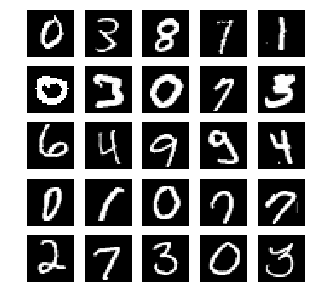

In [4]:
# load data
from tensorflow.examples.tutorials import mnist
directory = '/Users/gamal/git_local_repo/code_challenge/data/'
mnist_data = mnist.input_data.read_data_sets(directory + 'data/MNIST', one_hot=True)
l = mnist_data.train.images.shape[1]
plot_digits(mnist_data.train.next_batch(25)[0])

In [5]:
g = tf.Graph()
with g.as_default():
    # Discriminator network
    layer_sizes = (784, 150, 1)
    ip_imgs = tf.placeholder(shape=[None, layer_sizes[0]], dtype=tf.float32) # input to network
    D = neural_net(layer_sizes=layer_sizes)

    # Generator network
    latent_size = 100
    layer_sizes = (latent_size, 150, 784)
    Z = tf.placeholder(shape=[None, latent_size], dtype=tf.float32)
    G = neural_net(layer_sizes=layer_sizes)
    # define losses
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D.get_logits(ip_imgs), \
                                                                    labels = tf.ones_like(D.get_logits(ip_imgs))))+ \
             tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D.get_logits(G.out(Z)), \
                                                                    labels = tf.zeros_like(D.get_logits(G.out(Z)))))
        
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D.get_logits(G.out(Z)), \
                                                                    labels = tf.ones_like(D.get_logits(G.out(Z)))))
    
    # solvers 
    learning_rate = 0.001
    optimize_D = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list = D.weights+D.biases)
    optimize_G = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list = G.weights+G.biases)

    init = tf.global_variables_initializer()

In [6]:
max_iter = 1000000
batch_size = 50
with tf.Session(graph=g) as sess:
    init.run()
    for i in range(max_iter):
        feed_dict = {ip_imgs: mnist_data.train.next_batch(batch_size)[0], Z: sample_z(batch_size, latent_size)}
        for k in range(1):
            _, D_l = sess.run([optimize_D, D_loss], feed_dict=feed_dict)
        feed_dict = {Z: sample_z(batch_size, latent_size)}
        _, G_l = sess.run([optimize_G, G_loss], feed_dict=feed_dict)

        if i%5000==0:
            print (i, D_l, G_l)
    feed_dict = {Z: sample_z(100, latent_size)}
    final_samples = sess.run(G.out(Z), feed_dict=feed_dict)
    

(0, 1.3264678, 2.500936)
(5000, 0.28091788, 4.3180895)
(10000, 0.66182625, 3.0020902)
(15000, 0.81345654, 2.742281)
(20000, 0.42766285, 2.6074212)
(25000, 0.74447531, 2.2380106)
(30000, 0.7185269, 2.328655)
(35000, 0.62095451, 2.1400647)
(40000, 0.64916265, 2.0993416)
(45000, 0.73414779, 2.6038151)
(50000, 0.75045967, 2.9043057)
(55000, 0.55910391, 2.8532152)
(60000, 0.59621251, 2.0654969)
(65000, 0.61445439, 2.7169113)
(70000, 0.62390834, 2.5667019)
(75000, 0.61693996, 2.575206)
(80000, 0.70466465, 2.1589124)
(85000, 0.47762564, 2.3867893)
(90000, 0.60462821, 2.927985)
(95000, 0.66259164, 1.9366333)
(100000, 0.5228191, 2.9723268)
(105000, 0.4147591, 2.9067461)
(110000, 0.4918564, 2.7501068)
(115000, 0.44076142, 2.7868338)
(120000, 0.60585493, 2.7997406)
(125000, 0.64296806, 2.6883652)
(130000, 0.73623776, 2.6146843)
(135000, 0.61279261, 2.9170806)
(140000, 0.53701276, 2.7530015)
(145000, 0.52535129, 2.3268251)
(150000, 0.58358961, 2.4778478)
(155000, 0.51873785, 2.7439432)
(160000, 0.

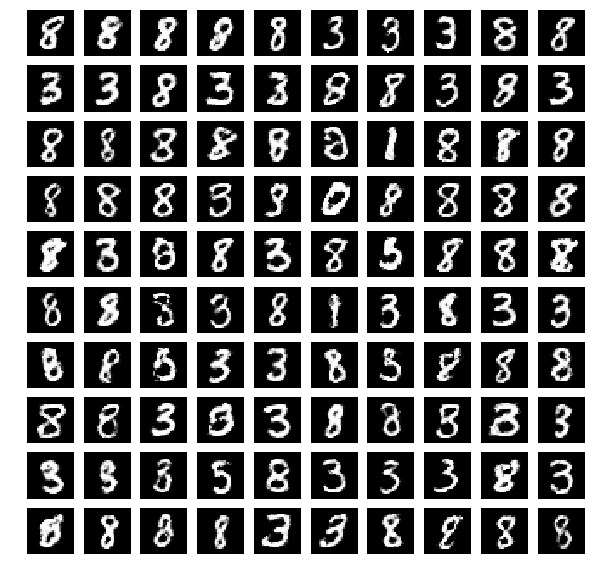

In [7]:
plot_digits(final_samples)

# Useful Refs
https://arxiv.org/pdf/1406.2661.pdf

http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/

https://github.com/hwalsuklee/tensorflow-GAN-1d-gaussian-ex

http://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/

https://blog.openai.com/generative-models/

https://arxiv.org/pdf/1701.00160.pdf


https://www.youtube.com/watch?v=RvgYvHyT15E